# A2 - Complex Networks
### Authors: Ignacio Miguel Rodríguez and Daniel Arias Cámara

The objective of this activity is to understand how community detection algorithms work and some of the recurrent nuances appearing when using these tools to characterize the mesoscale of complex networks. The activity is divided into two different tasks.

## Part 1: Characterization of the community structure of networks with block structure

In this part of the activity, you will use community detection algorithms to analyze the community structure of networks generated according to the stochastic block model (SBM). The parameters characterizing the networks are:

- **_N=300_**: number of nodes. For all the networks.
- **_nblocks=5_**: number of different blocks (types) of nodes. For all the networks.
- **_prs=0.02_**: Probability that a node (belonging to a given block) establishes a link with another node from a different block. For all networks here studied.
- **_prr=0.04_**: Probability that a single node (belonging to a given block) establishes a link with another node from the same block. This indicator varies across networks, being its value indicated in each filename. For example, for the synthetic network in file ‘synthetic_network_N_300_blocks_5_prr_0.04_prs_0.02.net’.

You should use at least three algorithms to find the community structure of the different networks provided in the dataset, i.e., as prr varies from prr=0 (no connections inside each block) to prr=1 (all-to-all interactions inside blocks). Out of these three algorithms, one should be **Infomap** whereas the other two should be **modularity maximization algorithms**, e.g., Girvan-Newman, Agglomerative Greedy algorithm, Louvain, Leiden, etc. Note that, for all the synthetic networks, the ‘true’ group structure is known. Namely, the first 60 nodes (labeled as 1, 2, 3, …,60) are contained in group 1, the next 60 (labeled 60, 62, ..., 120) in group 2, and so on. 

The report must include:

1. Evolution of the number of communities and the modularity of the partitions found by each algorithm as a function of prr. You should also compare the partition found by each algorithm with the ‘true’ partition using at least the following standard measures: Jaccard Index, Normalized Mutual Information (arithmetic normalization), and Normalized Variation of Information. It is not necessary to implement the calculation of these indices, you may use any program. Beware that you may find implementations of the Jaccard Index that are not related to community detection, thus the results would be incorrect.

2. A color-coded visualization of the community structure of the network for prr=0.02, prr=0.16, and prr=1.00. To facilitate the comparison of partitions, you should set the position of the nodes in the network by applying any of the algorithms available for representation (e.g., Kamada-Kawai, ForceAtlas, Fruchterman-Reingold, etc.) to the network with prr=1.00. The positions obtained for each node should be kept when representing the other two networks. In each network, the node's color should identify the community assigned by each community detection algorithm. 

3. A brief discussion on the limitations of the use of modularity to classify whether a network has community structure or not. For instance, from your results, can we state that a network with Q=0.4 has community structure? Why?

4. A brief discussion of the differences observed across algorithms. Are the communities detected by both of them equal? Are the modularity values obtained equal? Why?

### 1. Infomap algorithm

#### 1.1 Evolution of communities


Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.00_prs_0.02.net
  Infomap v2.8.0 starts at 2025-04-03 16:15:05
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 16 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 300 nodes and 728 links...
  -> One-level codelength: 8.10656546

Trial 1/1 starting at 2025-04-03 16:15:05
Two-level compression: 8.5% 1.6% 
Partitioned to codelength 2.6901437 + 4.60752494 = 7.297668641 in 33 modules.
Super-level compression: to codelength 7.297668641 in 33 top modules.

Recursive sub-structure compression: 0% . Found 2 levels with codelength 7.297668641

=> Trial 1/1 finished in 0.00353943s with codelength 7.29766864


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of m

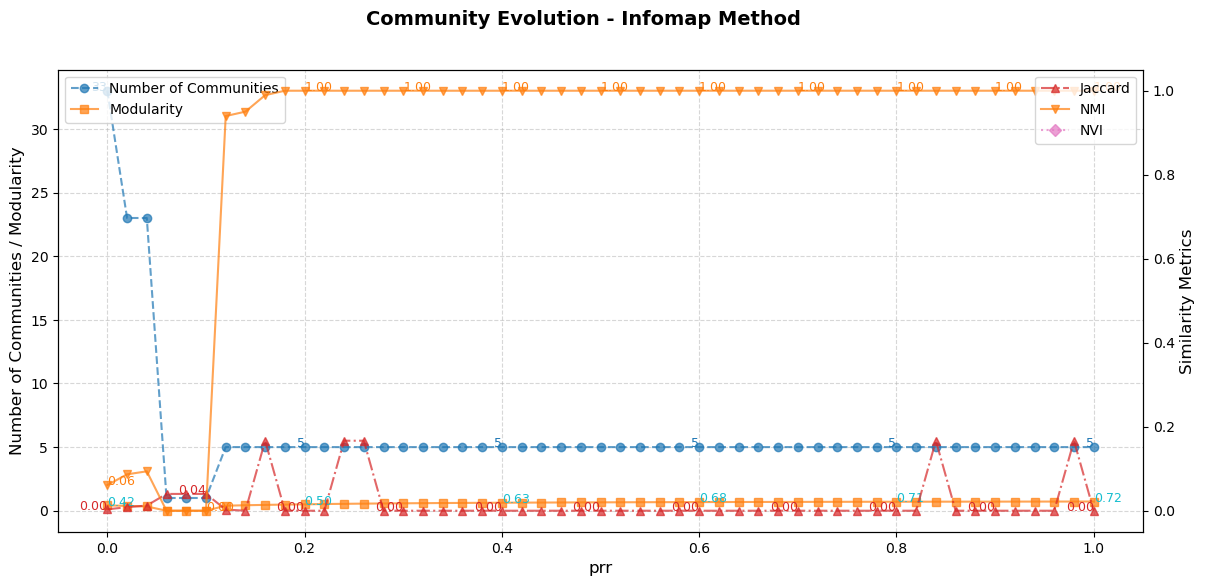

In [1]:
from utils import analyze_network_evolution, plot_results, visualize_communities

method = "infomap"
results = analyze_network_evolution(method)
plot_results(results, method)

#### 1.2 Network visualization

  Infomap v2.8.0 starts at 2025-04-03 16:15:10
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 16 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 300 nodes and 917 links...
  -> One-level codelength: 8.12761271

Trial 1/1 starting at 2025-04-03 16:15:10
Two-level compression: 3.3% 1.2% 
Partitioned to codelength 2.39735547 + 5.37110513 = 7.768460593 in 23 (22 non-trivial) modules.
Super-level compression: to codelength 7.768460593 in 23 top modules.

Recursive sub-structure compression: 0% . Found 2 levels with codelength 7.768460593

=> Trial 1/1 finished in 0.007554936s with codelength 7.76846059


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [         23,           0] (sum: 23)
Per level number of leaf 

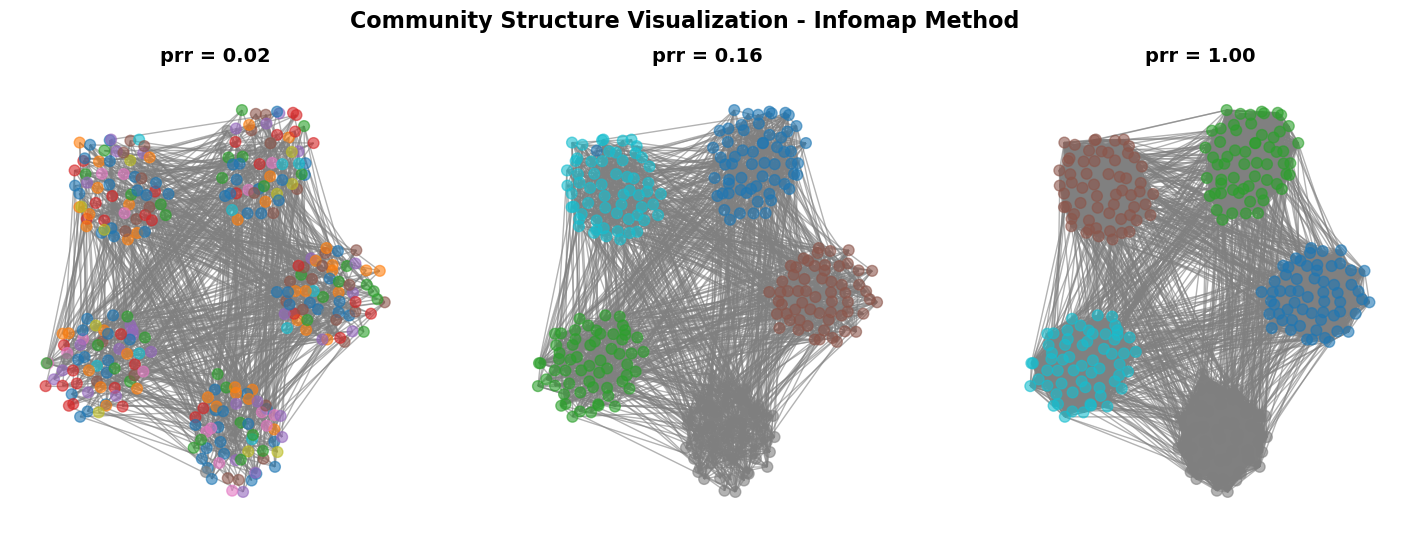

In [2]:
visualize_communities(method)

### 2. Louvain algorithm

#### 2.1 Evolution of communities

Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.00_prs_0.02.net
prr=0.00 | Communities: 10 | Modularity: 0.4525 | Jaccard: 0.0445 | NMI: 0.0186 | NVI: 0.5565
Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.02_prs_0.02.net
prr=0.02 | Communities: 11 | Modularity: 0.3789 | Jaccard: 0.0217 | NMI: 0.0336 | NVI: 0.6522
Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.04_prs_0.02.net
prr=0.04 | Communities: 12 | Modularity: 0.3316 | Jaccard: 0.0307 | NMI: 0.0692 | NVI: 0.6755
Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.06_prs_0.02.net
prr=0.06 | Communities: 10 | Modularity: 0.3145 | Jaccard: 0.0239 | NMI: 0.0672 | NVI: 0.6240
Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.08_prs_0.02.net
prr=0.08 | Communities: 9 | Modularity: 0.3070 | Jaccard: 0.0429 | NMI: 0.2438 | NVI: 0.4474
Processing network: A3_synthetic_networks/synt

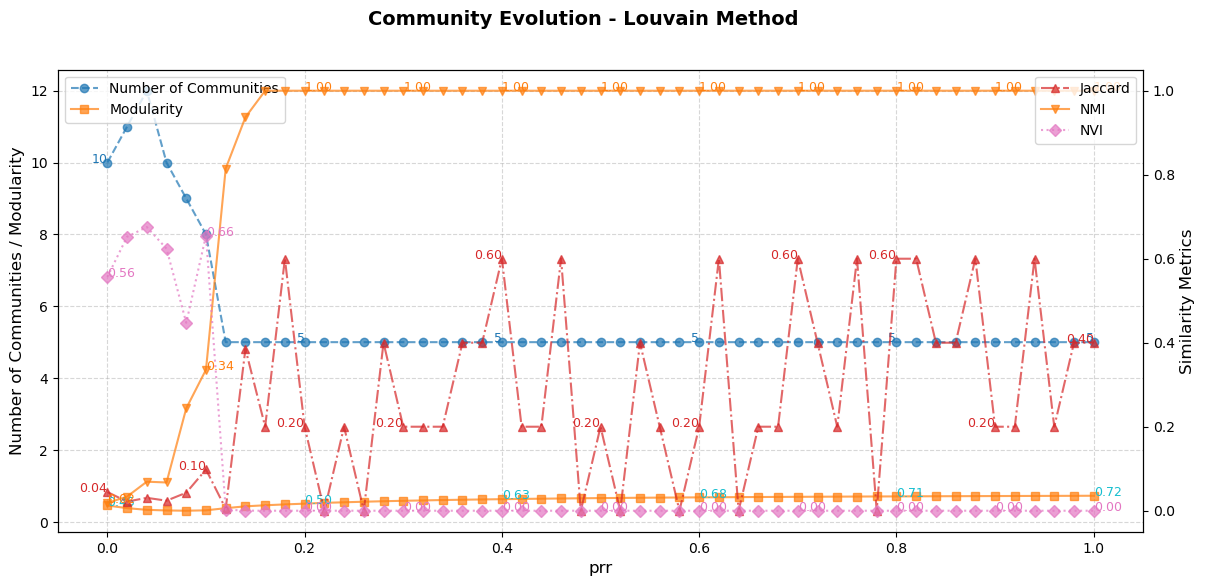

In [3]:
from utils import analyze_network_evolution, plot_results

method = "louvain"
results = analyze_network_evolution(method)
plot_results(results, method)

#### 2.2 Network visualization

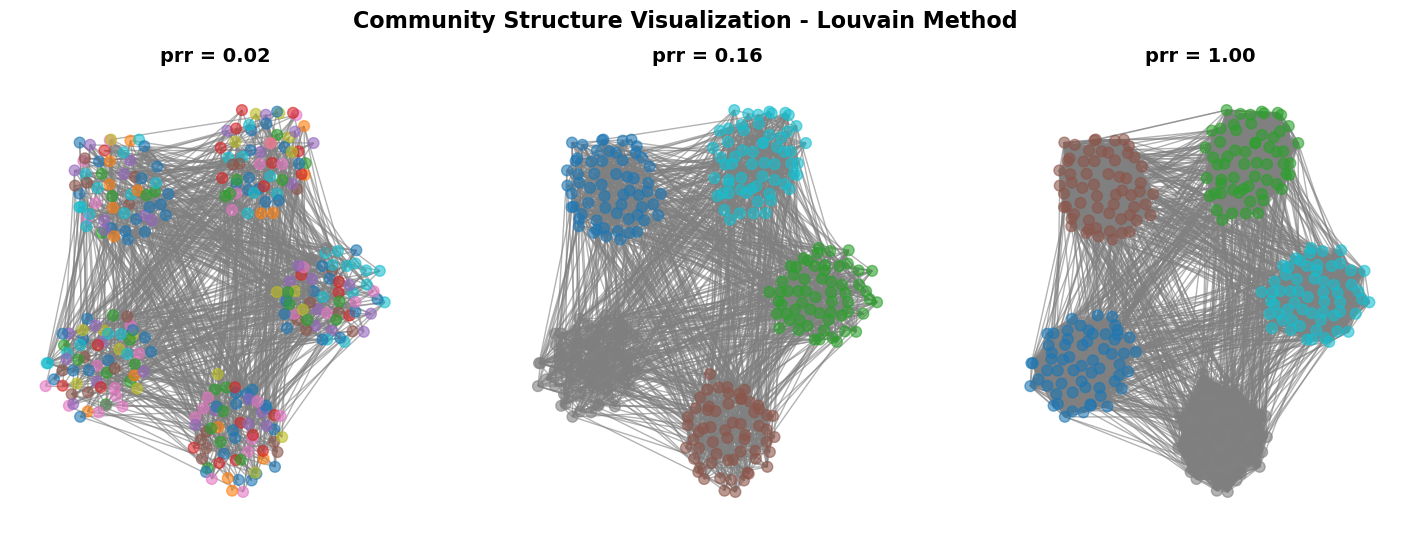

In [4]:
visualize_communities(method)

### 3. Girvan-Newman algorithm

#### 3.1 Evolution of communities

Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.00_prs_0.02.net
prr=0.00 | Communities: 2 | Modularity: 0.0135 | Jaccard: 0.0438 | NMI: 0.0055 | NVI: inf
Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.02_prs_0.02.net
prr=0.02 | Communities: 3 | Modularity: 0.0022 | Jaccard: 0.0429 | NMI: 0.0138 | NVI: inf
Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.04_prs_0.02.net
prr=0.04 | Communities: 3 | Modularity: -0.0000 | Jaccard: 0.0395 | NMI: 0.0130 | NVI: inf
Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.06_prs_0.02.net
prr=0.06 | Communities: 2 | Modularity: -0.0000 | Jaccard: 0.0435 | NMI: 0.0066 | NVI: inf
Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.08_prs_0.02.net
prr=0.08 | Communities: 2 | Modularity: -0.0000 | Jaccard: 0.0435 | NMI: 0.0066 | NVI: inf
Processing network: A3_synthetic_networks/synthetic_network_N_

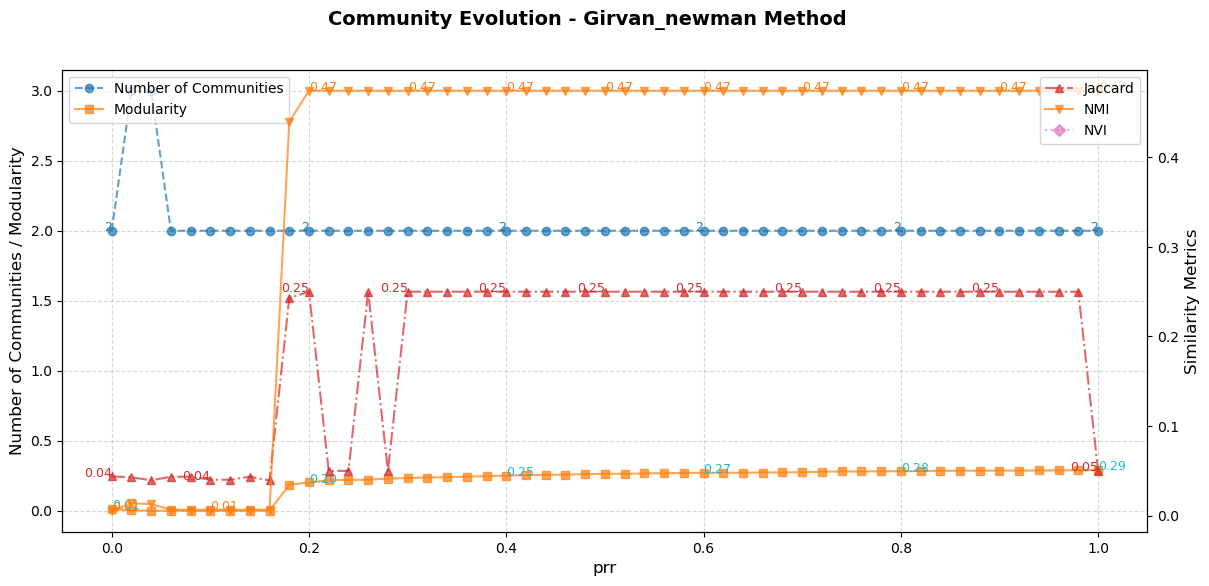

In [5]:
from utils import analyze_network_evolution, plot_results

method = "girvan_newman"
results = analyze_network_evolution(method)
plot_results(results, method)

## Part 2: Characterization of the community structure of real networks

In this part of the activity, you should use algorithms relying on modularity maximization to analyze the community structure of a real network capturing face-to-face interactions in a primary school in France. In this network, nodes represent either students or teachers and weights are proportional to the time they were together during the two days in which interactions were measured. More information on the network can be found here: 

http://www.sociopatterns.org/publications/high-resolution-measurements-of-face-to-face-contact-patterns-in-a-primary-school/

You should analyze both the unweighted (‘primaryschool_u.net’) and the weighted (‘primaryschool_w.net’) versions of this network. In addition, node metadata is available (metadata_primary_school.txt), indicating the school group each individual belongs to.

The report must include:

1. A comparison between the community structure found in both the unweighted and the weighted networks. Use a color-coded representation, similar to the one explained in the previous activity. The position of the nodes should be set by applying the chosen positioning algorithm to the weighted network. **Warning**: If you choose the Kamada-Kawai layout algorithm to visualize the network, the weights introduced in the algorithm should be the inverse (1/wij) of the actual weights (wij) of the network. Nonetheless, you should keep using the actual weights for community detection.

2. The composition of the detected communities in terms of the school groups to which their individuals belong. You should provide a visual representation (e.g. a stacked bar plot, a pie chart) to show how many individuals of each school group are in each community.

3. A brief discussion on the differences among the communities detected in the weighted and unweighted network. Why weights are relevant?